# MAPAS COM DADOS DE ADCP DE CASCO

A seguir serão descritas as etapas para plotagem de dados de ADCP de casco provenientes de um arquivo ".NC"
Este arquivo ".NC" é resultado da última rotina de processamento de dados de ADCP de casco usando o OSSI

## Importando as bibliotecas necessárias

In [1]:
import numpy as np
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from numpy import cos, sin, arcsin, sqrt
from math import radians

## Declarando função que calcula distância entre pontos

In [2]:
def haversine(row, lon1, lat1):
    lon2 = row['lon']
    lat2 = row['lat']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    km = 6367 * c
    return km

## Importando arquivo referente a comissão que será trabalhada

Importante sempre padronizar e colocar seus arquivos ".NC" na pasta "data"

### 👇 Coloque o nome do arquivo aqui

In [3]:
file_name = "Comissao_PC1848_150.nc"

### Abrindo o arquivo ".NC"

In [4]:
nc = Dataset(f'data/{file_name}')

In [5]:
uu = nc['u'][:]
vv = nc['v'][:]
depth = nc['Depth'][:]
lat = nc['Latitude'][:]
lon = nc['Longitude'][:]


### Transformando a matriz de dados em um vetor de dados

Ou seja, transformando uma matriz (i x j) para (i * j)

In [6]:
depth = np.array([depth[0,:]]*lat.shape[0])
lat = np.array([lat[:,0]]*depth.shape[1]).T
lon = np.array([lon[:,0]]*depth.shape[1]).T

i = lat.shape[0]
j = lat.shape[1]
lat = lat.reshape(i*j)
lon = lon.reshape(i*j)
depth = depth.reshape(i*j)
u = uu.reshape(i*j)
v = vv.reshape(i*j)

### Criando o dataframe em pandas

O pandas é um conjunto de rotinas em python que facilita trabalhar com dados em tabelas

In [7]:
df = pd.DataFrame(np.array([lat, lon, depth, u, v]).T, columns=['lat', 'lon', 'depth', 'u', 'v'])
DF = df

## Plotando o mapa de correntes

Inicialmente vamos plotar os dados em um mapa interativo.

Nesse mapa, você pode alterar a lat, lon e outras informações do dado de modo a obter um mapa mais próximo de suas necessidades.

As seguintes características podem ser alteradas:

depth_plot = profundidade que será plotada na figura

a = índica do início do dado a ser plotado

b = índice do final do dado a ser plotado

lat_s = latitude sul da figura

lat_n = latitude norte da figura

lon_w = longitude oeste da figura

lon_e = longitude leste da figura

scale = escala dos setas a serem plotadas

skip = número de dados que serão pulados na figura final, de modo a diminuir a poluição visual da figura

title_fig = título da figura. O código de plotagem irá adicionar a profundidade de coleta automaticamente.

In [11]:
@interact
def plot_map(depth_plot=DF['depth'].unique(),a=widgets.IntSlider(min=0, max=len(df), step=5, value=0),b=widgets.IntSlider(min=0, max=len(df), step=5, value=95), skip=widgets.IntSlider(min=1, max=10, step=1, value=1), lat_s=widgets.IntSlider(min=-30, max=-20, step=1, value=-24), lat_n=widgets.IntSlider(min=-25, max=-10, step=1, value=-23), lon_w=widgets.IntSlider(min=-50, max=-40, step=1, value=-44), lon_e=widgets.IntSlider(min=-45, max=-35, step=1, value=-42), scale=widgets.IntSlider(min=1, max=100, step=5, value=5)):
    df_select = DF[DF['depth'] == depth_plot]

    LAT = df_select['lat']
    LON = df_select['lon']
    U = df_select['u'].rolling(window=5).mean()
    V = df_select['v'].rolling(window=5).mean()    

    plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

    ax.set_xticks(np.linspace(lon_w, lon_e, (lon_e - lon_w)*3).round(2), crs=ccrs.PlateCarree())
    ax.set_xticklabels(np.linspace(lon_w, lon_e, (lon_e - lon_w)*3).round(2), fontdict={'fontsize': 20})
    ax.set_yticks(np.linspace(lat_s, lat_n, (lat_n - lat_s)*3).round(2), crs=ccrs.PlateCarree())
    ax.set_yticklabels(np.linspace(lat_s, lat_n, (lat_n - lat_s)*3).round(2),fontdict={'fontsize': 20})

    ax.gridlines(xlocs=np.linspace(lon_w, lon_e, (lon_e - lon_w)*3).round(2), ylocs=np.linspace(lat_s, lat_n, (lat_n - lat_s)*3))
    
    ax.set_extent([lon_w, lon_e, lat_s, lat_n], ccrs.PlateCarree())
    # img_extent = (-120.67660000000001, -106.32104523100001, 13.2301484511245, 30.766899999999502)

    qv1 = ax.quiver(df_select['lon'].iloc[a:b:skip], df_select['lat'].iloc[a:b:skip], df_select['u'].iloc[a:b:skip], df_select['v'].iloc[a:b:skip], scale=scale, width=0.002, headwidth=2, headlength=1.5 )

    ax.quiverkey(qv1, lon_w + 0.1, lat_n - 0.1, 0.5, '0.5 m/s', coordinates='data', fontproperties={'size': 20})
    
# plt.show()

interactive(children=(Dropdown(description='depth_plot', options=(15.9, 23.9, 31.9, 39.9, 47.9, 55.9, 63.9, 71…

### Criando figura a ser exportada

Com as características obtidas no mapa acima, você pode gerar agora o mapa final para gerar a figura a ser exportada

depth_plot = profundidade que será plotada na figura

a = índica do início do dado a ser plotado

b = índice do final do dado a ser plotado

lat_s = latitude sul da figura

lat_n = latitude norte da figura

lon_w = longitude oeste da figura

lon_e = longitude leste da figura

scale = escala dos setas a serem plotadas

skip = número de dados que serão pulados na figura final, de modo a diminuir a poluição visual da figura

title_fig = título da figura. O código de plotagem irá adicionar a profundidade de coleta automaticamente.

name_file = nome do arquivo final. O código de plotagem irá adicionar a profundidade de coleta automaticamente.

#### 👇 Coloque os dados da figura aqui

In [394]:
depth_plot = 15.9
a = 0
b = 225
lat_s = -24
lat_n = -22
lon_w = -43
lon_e = -40
scale = 11
skip = 1
title_fig = 'Correntes Comissao'
name_file = 'comissao'

Plotando a figura final do mapa de correntes

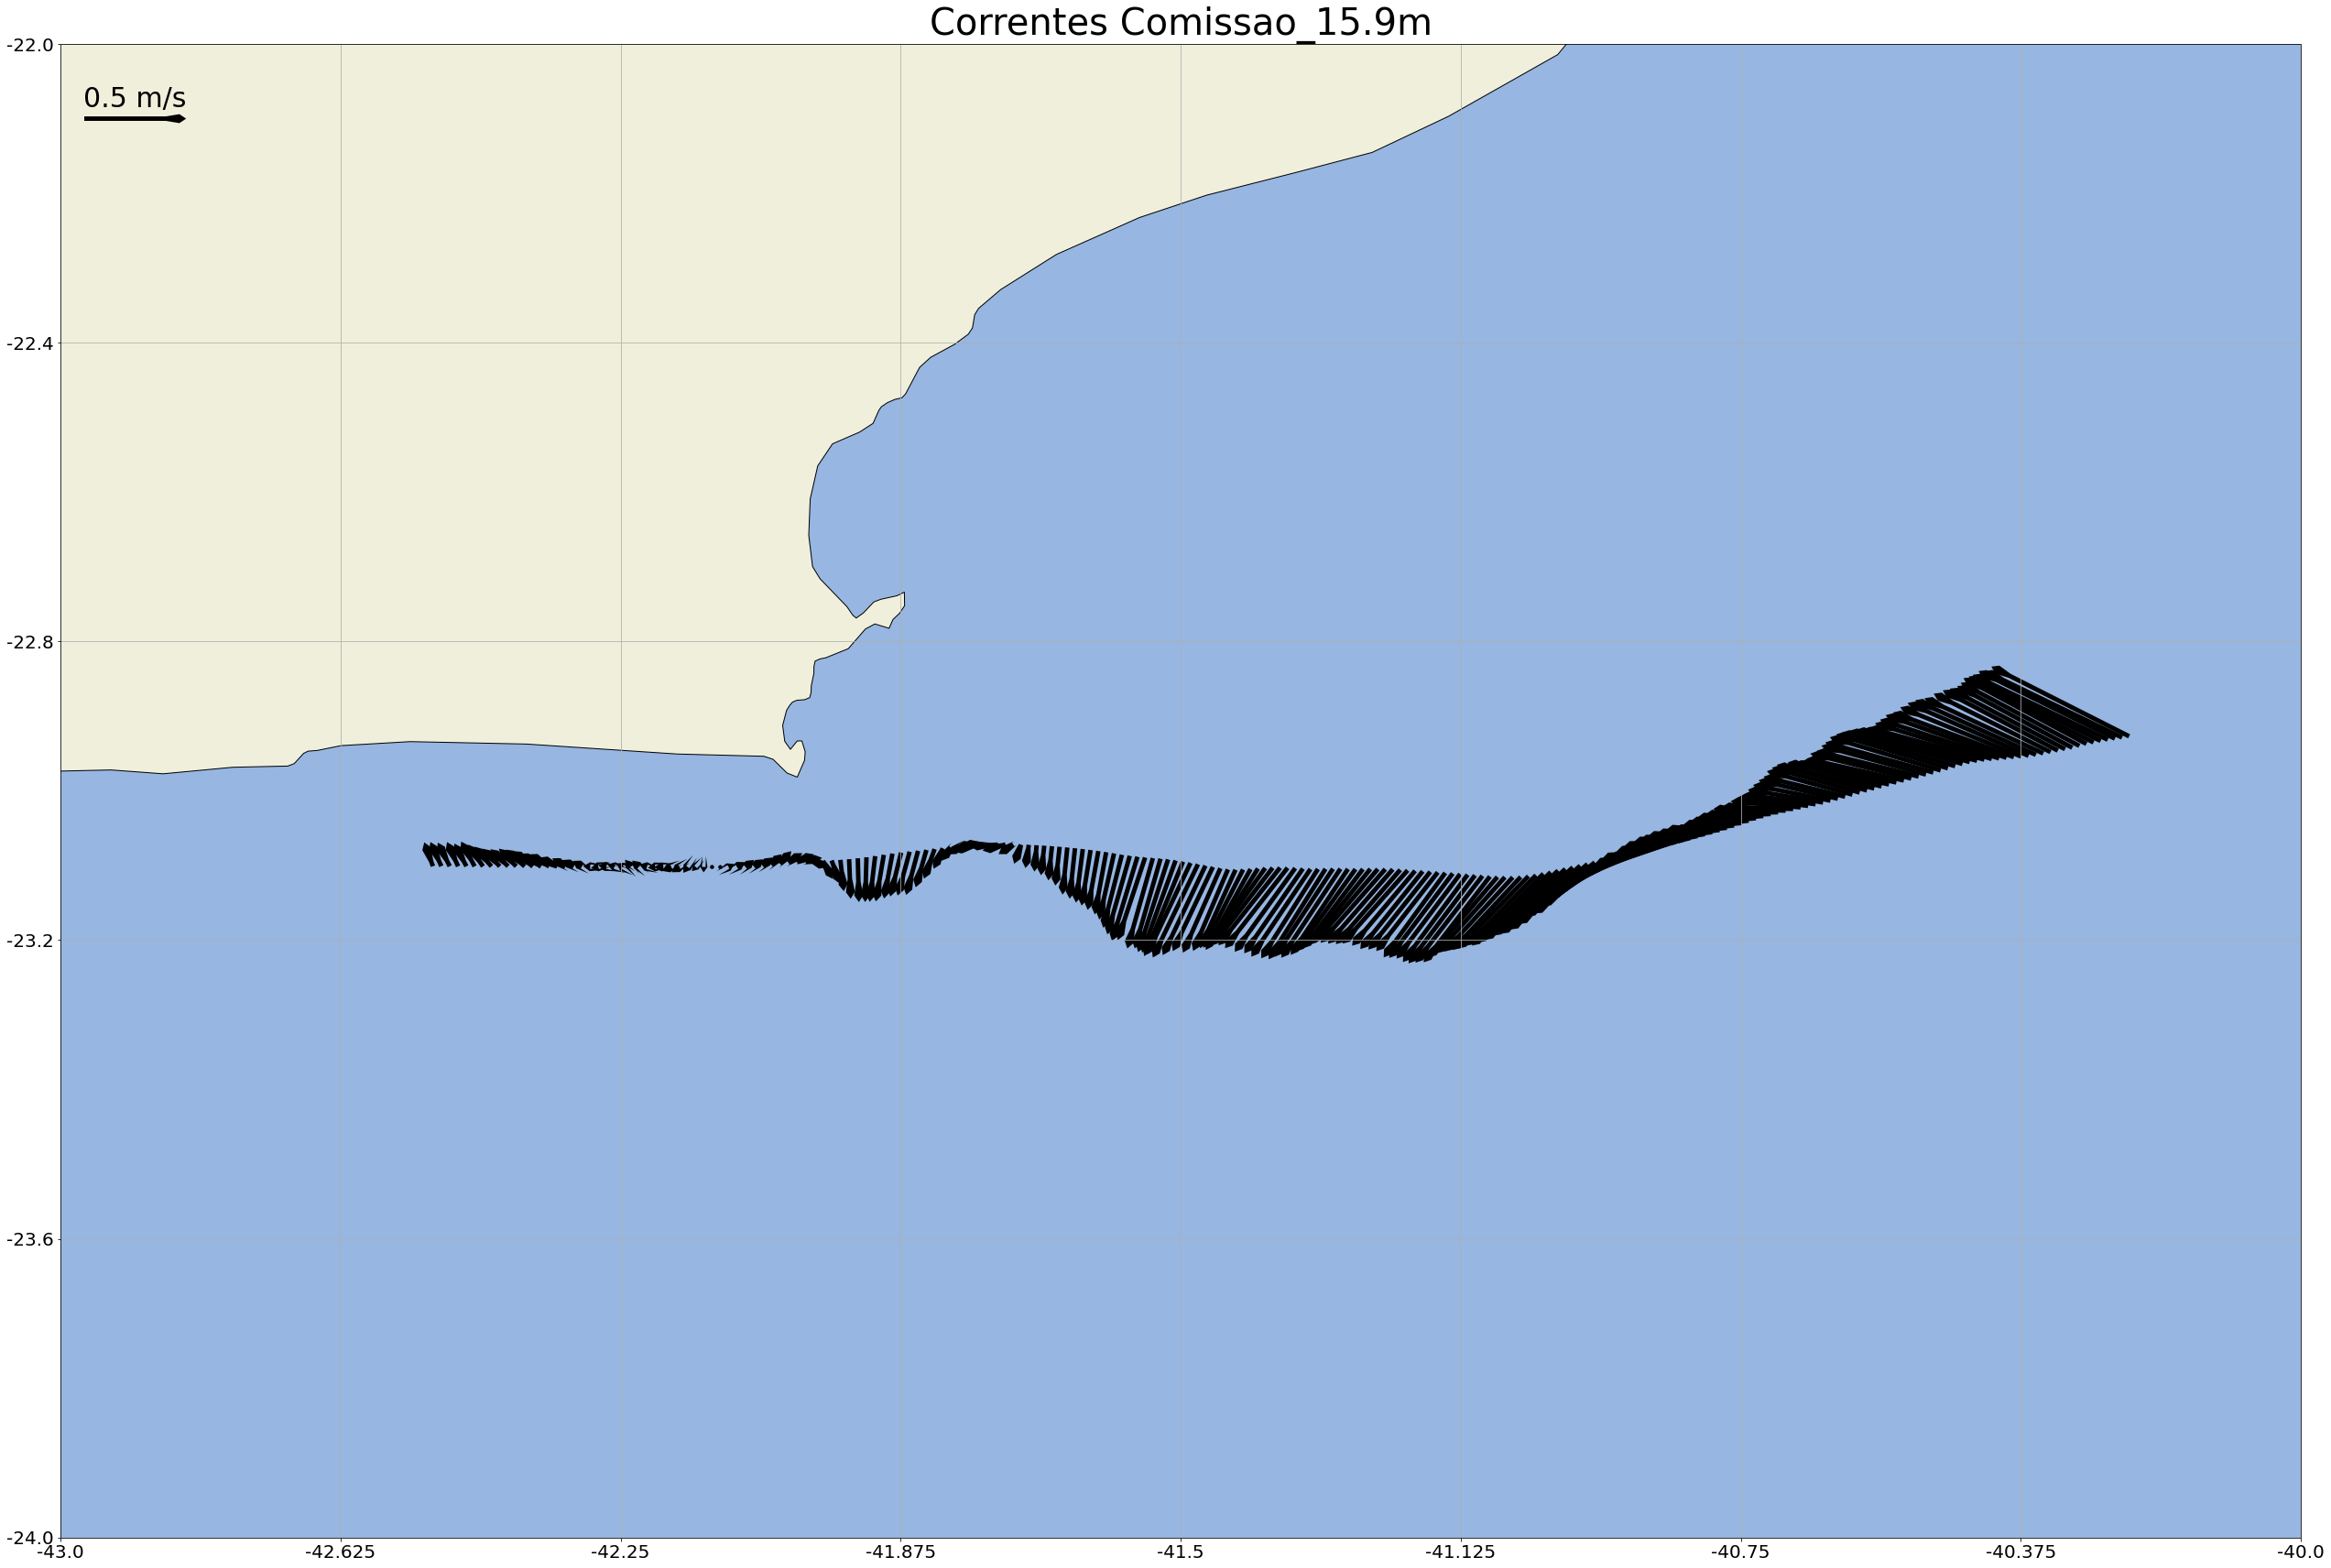

In [395]:
df_select = df[df['depth'] == depth_plot]
df_select['u'] = df_select['u'].rolling(window=5).mean()
df_select['v'] = df_select['v'].rolling(window=5).mean()
latlim = (df_select.lat.iloc[a], df_select.lat.iloc[b])
lonlim = (df_select.lon.iloc[a], df_select.lon.iloc[b])

plt.figure(figsize=(50, 30))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

ax.set_xticks(np.linspace(lon_w, lon_e, (lon_e - lon_w)*3), crs=ccrs.PlateCarree())
ax.set_xticklabels(np.linspace(lon_w, lon_e, (lon_e - lon_w)*3), fontdict={'fontsize': 20})
ax.set_yticks(np.linspace(lat_s, lat_n, (lat_n - lat_s)*3), crs=ccrs.PlateCarree())
ax.set_yticklabels(np.linspace(lat_s, lat_n, (lat_n - lat_s)*3),fontdict={'fontsize': 20})

ax.gridlines(xlocs=np.linspace(lon_w, lon_e, (lon_e - lon_w)*3), ylocs=np.linspace(lat_s, lat_n, (lat_n - lat_s)*3))
ax.set_extent([lon_w, lon_e, lat_s, lat_n], ccrs.PlateCarree())

ax.set_title(f'{title_fig}_{depth_plot}m', fontdict={'fontsize': 40})
qv1 = ax.quiver(df_select['lon'].iloc[a:b:skip], df_select['lat'].iloc[a:b:skip], df_select['u'].iloc[a:b:skip], df_select['v'].iloc[a:b:skip], scale=scale, width=0.002, headwidth=2, headlength=1.5)
ax.quiverkey(qv1, lon_w + 0.1, lat_n - 0.1, 0.5, '0.5 m/s', coordinates='data', fontproperties={'size': 30})

plt.savefig(f'{name_file}_{depth_plot}m.png')


## Plotando o gráfico de perfil vertical de correntes

Inicialmente vamos plotar os dados em um mapa interativo.

Nesse mapa, você pode alterar a lat, lon e outras informações do dado de modo a obter um mapa mais próximo de suas necessidades.

As seguintes características podem ser alteradas:

grid_method = método de grid a ser utilizado para gerar a figura. Recomenda-se linear

lat_min = latitude inicial do dado a ser interpolado

lat_max = latitude final do dado a ser interpolado

lon_min = longitude inicial do dado a ser interpolado

lon_max = longitude final do dado a ser interpolado

levels = número de níveis para a interpolação, ou seja, resolução da interpolação. Quanto maior, melhor a resolução

depth_grid = espaçamento vertical do grid de interpolação (em metros)

distance_grid = espaçamento horizontal do grid de interpolação (em metros)

contour_div = número de divisões de linhas de contorno a serem plotadas no gráfico

depth_graph = profundidade máxima a ser plotada no gráfico

In [396]:
x = np.array([1,2,3,4,5,6,7,8,9,10])
x[::round(len(x)/2)]

array([1, 6])

In [403]:
@interact
def plot_map(grid_method=['linear', 'cubic', 'nearest'], lat_min=widgets.FloatSlider(min=DF['lat'].min(), max=DF['lat'].max(), step=0.1, value=latlim[0]), lat_max=widgets.FloatSlider(min=DF['lat'].min(), max=DF['lat'].max(), step=0.1, value=latlim[1]), lon_min=widgets.FloatSlider(min=DF['lon'].min(), max=DF['lon'].max(), step=0.1, value=lonlim[0]), lon_max=widgets.FloatSlider(min=DF['lon'].min(), max=DF['lon'].max(), step=0.1, value=lonlim[1]), levels=list(range(10, 60)), depth_grid = list(range(1, 40)), distance_grid = list(range(1, 40)), contour_div = list(range(2, 40)), depth_graph = list(-DF['depth'].unique()[4:])):

    df_grid = DF.loc[(DF['lat'] >= lat_min)&(DF['lat'] <= lat_max)&(DF['lon'] >= lon_min)&(DF['lon'] <= lon_max)] 
    df_grid['distance'] = df_grid.apply(lambda row: haversine(row, df_grid['lon'].iloc[0], df_grid['lat'].iloc[0]), axis=1)
    x = np.linspace(df_grid['distance'].min(), df_grid['distance'].max(), round((df_grid['distance'].max() - df_grid['distance'].min()) / distance_grid))
    y = np.linspace(df_grid['depth'].min(), df_grid['depth'].max(), round((df_grid['depth'].max() - df_grid['depth'].min()) / depth_grid))
    xx, yy = np.meshgrid(x, y)
    zz = griddata((df_grid['distance'], df_grid['depth']), df_grid['v'], (xx, yy), method=grid_method)

    fig1, ax2 = plt.subplots(figsize=(20,10))

    CS = ax2.contourf(xx, -yy, zz, levels, cmap=plt.cm.RdBu)

    contour_div = round(len(CS.levels)/contour_div)
    if contour_div == 0:
        contour_div = 1
    CS2 = ax2.contour(CS, levels=CS.levels[::contour_div], colors='k')

    ax2.set_title('Correntes')

    ax2.set_xlabel('Distancia (km)')
    ax2.set_ylabel('Profundidade (m)')
    
    ax2.set_ylim(depth_graph, -DF['depth'].min())

    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = fig1.colorbar(CS)
    cbar.ax.set_ylabel('Correntes em V (m/s)')
    # Add the contour line levels to the colorbar
    cbar.add_lines(CS2)

interactive(children=(Dropdown(description='grid_method', options=('linear', 'cubic', 'nearest'), value='linea…

### Criando figura a ser exportada

Com as características obtidas na figura interpolada acima, você pode gerar agora o gráfico final para gerar a figura a ser exportada

grid_method = método de grid a ser utilizado para gerar a figura. Recomenda-se linear

lat_min = latitude inicial do dado a ser interpolado

lat_max = latitude final do dado a ser interpolado

lon_min = longitude inicial do dado a ser interpolado

lon_max = longitude final do dado a ser interpolado

levels = número de níveis para a interpolação, ou seja, resolução da interpolação. Quanto maior, melhor a resolução

depth_grid = espaçamento vertical do grid de interpolação (em metros)

distance_grid = espaçamento horizontal do grid de interpolação (em metros)

contour_div = número de divisões de linhas de contorno a serem plotadas no gráfico

depth_graph = profundidade máxima a ser plotada no gráfico

title_fig = título da figura.

name_file = nome do arquivo final.

#### 👇 Coloque os dados da figura aqui

In [404]:
grid_method = 'linear'

lat_min = -23.10

lat_max = -22.93

lon_min = -42.55

lon_max = -40.22

levels = 40

depth_grid = 1

distance_grid = 1

contour_div = 5

depth_graph = -447.9

title_fig = 'Correntes comissao'

name_file = 'correntes'

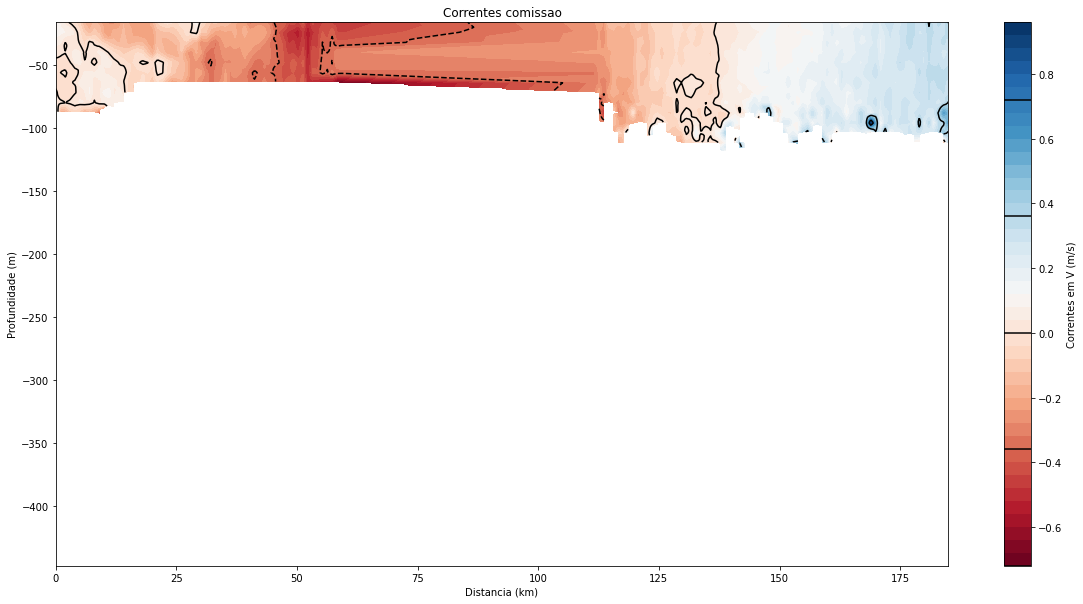

In [405]:
df_grid = DF.loc[(DF['lat'] >= lat_min)&(DF['lat'] <= lat_max)&(DF['lon'] >= lon_min)&(DF['lon'] <= lon_max)] 
df_grid['distance'] = df_grid.apply(lambda row: haversine(row, df_grid['lon'].iloc[0], df_grid['lat'].iloc[0]), axis=1)

x = np.linspace(df_grid['distance'].min(), df_grid['distance'].max(), round((df_grid['distance'].max() - df_grid['distance'].min()) / distance_grid))
y = np.linspace(df_grid['depth'].min(), df_grid['depth'].max(), round((df_grid['depth'].max() - df_grid['depth'].min()) / depth_grid))
xx, yy = np.meshgrid(x, y)
zz = griddata((df_grid['distance'], df_grid['depth']), df_grid['v'], (xx, yy), method=grid_method)

fig1, ax2 = plt.subplots(figsize=(20,10))

CS = ax2.contourf(xx, -yy, zz, levels, cmap=plt.cm.RdBu)

contour_div = round(len(CS.levels)/contour_div)
if contour_div == 0:
    contour_div = 1
CS2 = ax2.contour(CS, levels=CS.levels[::contour_div], colors='k')

ax2.set_title(title_fig)
ax2.set_xlabel('Distancia (km)')
ax2.set_ylabel('Profundidade (m)')
ax2.set_ylim(depth_graph, -DF['depth'].min())

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Correntes em V (m/s)')
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)
plt.savefig(f'{name_file}.png')

# FIM! 🚀🚀🚀